#MLP
Για την υλοποίηση του Multilayer Perceptron χρησιμοποιήθηκε το PyTorch framework. Το δίκτυο αποτελείται από πολλαπλά γραμμικά επίπεδα: ένα επίπεδο εισόδου, δύο κρυφά επίπεδα με 128 και 64 νευρώνες αντίστοιχα, και ένα επίπεδο εξόδου με αριθμό νευρώνων ίσο με τις κλάσεις του προβλήματος, εδω 4. Μεταξύ των επιπέδων χρησιμοποιείται η συνάρτηση ενεργοποίησης ReLU, καθώς και Batch Normalization και Dropout για πιο σταθερή εκπαίδευση και περιορισμό του overfitting. Επίσης γίνεται κανονικοποίηση δεδομένων με StandardScaler. Πριν την εκπαίδευση, τα labels του dataset μετατράπηκαν από συμβολοσειρές (strings) σε ακέραιες τιμές με χρήση Label Encoding, ώστε να μπορούν να χρησιμοποιηθούν από το μοντέλο και τη συνάρτηση κόστους.Η εκπαίδευση του δικτύου γίνεται με Cross Entropy loss και τον Adam optimizer, χρησιμοποιώντας mini-batches. Σε κάθε epoch παρακολουθείται τόσο το cross entropy loss στο train όσο και στο test set, καθώς και το accuracy, ώστε να αξιολογηθεί η πορεία της εκπαίδευσης και η γενίκευση του μοντέλου. Τέλος, παρουσιάζονται τα τελικά αποτελέσματα στο test set με χρήση accuracy και classification report.

X shape: (1728, 6) | y shape: (1728,)
y unique: ['acc' 'good' 'unacc' 'vgood']
Classes: ['acc' 'good' 'unacc' 'vgood']
Encoded X_train shape: (1382, 21) | Encoded X_test shape: (346, 21)
Epoch [1/100] | Train CE: 1.2392 | Test CE: 1.2631 | Train Acc: 0.4067 | Test Acc: 0.4335
Epoch [5/100] | Train CE: 0.3911 | Test CE: 0.4884 | Train Acc: 0.7851 | Test Acc: 0.7630
Epoch [10/100] | Train CE: 0.1895 | Test CE: 0.2808 | Train Acc: 0.9001 | Test Acc: 0.8410
Epoch [15/100] | Train CE: 0.1038 | Test CE: 0.1676 | Train Acc: 0.9580 | Test Acc: 0.9162
Epoch [20/100] | Train CE: 0.0719 | Test CE: 0.1405 | Train Acc: 0.9754 | Test Acc: 0.9335
Epoch [25/100] | Train CE: 0.0499 | Test CE: 0.1048 | Train Acc: 0.9819 | Test Acc: 0.9566
Epoch [30/100] | Train CE: 0.0409 | Test CE: 0.0843 | Train Acc: 0.9884 | Test Acc: 0.9711
Epoch [35/100] | Train CE: 0.0354 | Test CE: 0.0758 | Train Acc: 0.9863 | Test Acc: 0.9827
Epoch [40/100] | Train CE: 0.0308 | Test CE: 0.0665 | Train Acc: 0.9899 | Test Acc: 0.9

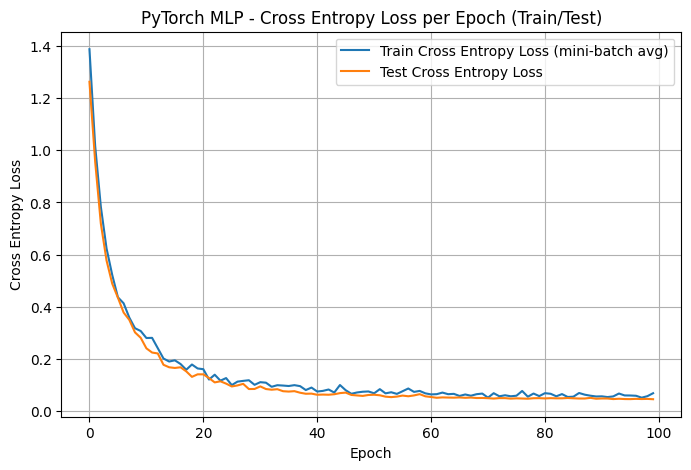

In [3]:
!pip -q install ucimlrepo

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


# -------------- Load Dataset -----------------
car = fetch_ucirepo(id=19)
X_df = car.data.features
y = car.data.targets.values.ravel()   # labels: unacc, acc, good, vgood

print("X shape:", X_df.shape, "| y shape:", y.shape)
print("y unique:", np.unique(y))

le = LabelEncoder()
y = le.fit_transform(y)   # strings -> 0..C-1
print("Classes:", le.classes_)

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=1234, stratify=y
)

# one-hot for categorical features
X_train = pd.get_dummies(X_train_df)
X_test  = pd.get_dummies(X_test_df)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.values.astype(np.float32)
X_test  = X_test.values.astype(np.float32)

print("Encoded X_train shape:", X_train.shape, "| Encoded X_test shape:", X_test.shape)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

batch_size = 128
train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


class_counts = np.bincount(y_train)
weights = (class_counts.sum() / (len(class_counts) * class_counts)).astype(np.float32)
weights_t = torch.tensor(weights, dtype=torch.float32).to(device)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

model = MLP(input_dim=input_dim, num_classes=num_classes, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_t)

# ---------------------------------------------------------
#train with SGD + Cross Entropy
# ---------------------------------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

epochs = 100
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(epochs):
    # -------- Train -----------
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)  #Cross Entropy
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------- Eval-----------
    model.eval()
    with torch.no_grad():
        logits_train = model(X_train_t)
        train_loss_full = criterion(logits_train, y_train_t).item()
        train_pred = torch.argmax(logits_train, dim=1)
        train_acc = (train_pred == y_train_t).float().mean().item()

        logits_test = model(X_test_t)
        test_loss = criterion(logits_test, y_test_t).item()
        test_pred = torch.argmax(logits_test, dim=1)
        test_acc = (test_pred == y_test_t).float().mean().item()

    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if (epoch + 1) % 5 == 0 or (epoch + 1) == 1:
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train CE: {train_loss_full:.4f} | Test CE: {test_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# ----------------Report-----------------
model.eval()
with torch.no_grad():
    logits_train = model(X_train_t)
    preds_train = torch.argmax(logits_train, dim=1).cpu().numpy()

    logits_test = model(X_test_t)
    preds_test = torch.argmax(logits_test, dim=1).cpu().numpy()

print("\n--- PyTorch MLP (SGD + Cross Entropy) ---")
print("Train Accuracy:", accuracy_score(y_train, preds_train))
print("Test Accuracy :", accuracy_score(y_test, preds_test))

print("\nTest Classification Report:")
print(classification_report(
    y_test, preds_test,
    target_names=le.classes_.astype(str),
    zero_division=0
))

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Cross Entropy Loss (mini-batch avg)")
plt.plot(test_losses, label="Test Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("PyTorch MLP - Cross Entropy Loss per Epoch (Train/Test)")
plt.legend()
plt.grid(True)
plt.show()
